============================== Caso 4 — SVR (RBF) ==============================

Mejores hiperparámetros (GridSearchCV):
{'svr__C': 0.1, 'svr__epsilon': 0.01, 'svr__gamma': 'scale'}

RMSE (test): 0.014218
MAE  (test): 0.012031
R^2  (test): -0.406904
Exactitud direccional (DA): 0.545455


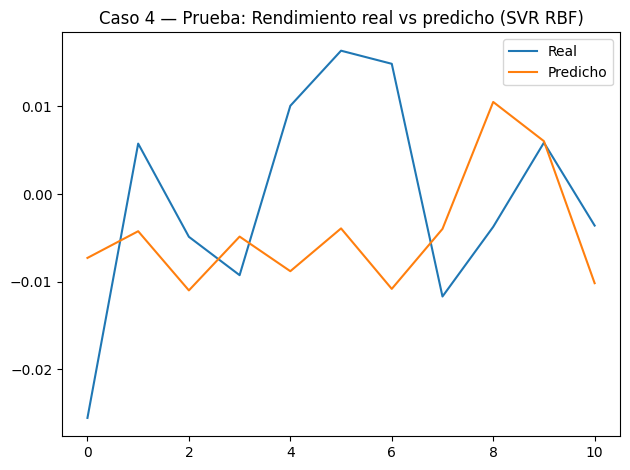

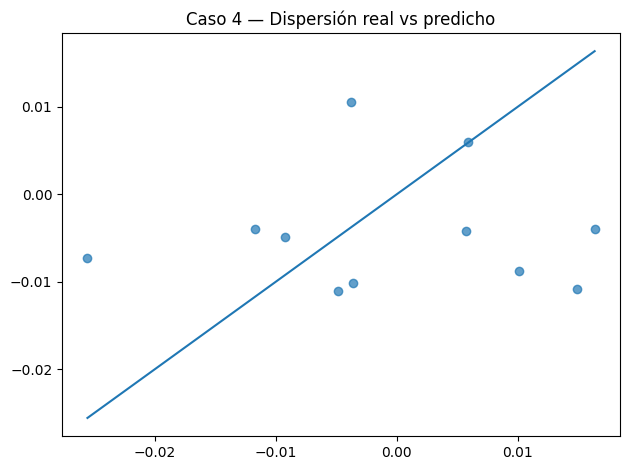


Conclusión breve:
El modelo no logra explicar la variación mejor que un promedio constante.
La dirección se captura por encima del azar; podría servir para una regla simple tipo 'si predicción > 0, entrar'.


In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt


ruta = "case1_tecnologia_growth.csv"
dataframe = pd.read_csv(ruta)

if 'return' not in dataframe.columns:
    raise ValueError("El CSV debe contener la columna 'return'.")


r = dataframe['return'].astype(float)
if r.abs().max() > 1:
    r = r / 100.0

df = pd.DataFrame({
    'return': r
})
for k in range(1, 6):
    df[f'lag{k}'] = df['return'].shift(k)


shift = df['return'].shift(1)
df['roll_mean_5'] = shift.rolling(window=5, min_periods=5).mean()
df['roll_std_5']  = shift.rolling(window=5, min_periods=5).std(ddof=1)

df = df.dropna().reset_index(drop=True)


columnas_x = [f'lag{k}' for k in range(1, 6)] + ['roll_mean_5', 'roll_std_5']
X = df[columnas_x].values
y = df['return'].values

n = len(df)
n_train = int(np.floor(0.8 * n))
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]


pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel='rbf'))
])

parametros = {
    "svr__C": [0.1, 1, 10, 100],
    "svr__gamma": ['scale', 0.1, 0.01],
    "svr__epsilon": [1e-4, 1e-3, 1e-2],
}

tscv = TimeSeriesSplit(n_splits=3)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=parametros,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1
)

grid.fit(X_train, y_train)

mejor_modelo = grid.best_estimator_
y_pred = mejor_modelo.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)


da = (np.sign(y_pred) == np.sign(y_test)).mean()


print(f"{'='*30} Caso 4 — SVR (RBF) {'='*30}\n")
print("Mejores hiperparámetros (GridSearchCV):")
print(grid.best_params_)
print(f"\nRMSE (test): {rmse:.6f}")
print(f"MAE  (test): {mae:.6f}")
print(f"R^2  (test): {r2:.6f}")
print(f"Exactitud direccional (DA): {da:.6f}")


plt.figure()
plt.plot(y_test, label="Real")
plt.plot(y_pred, label="Predicho")
plt.title("Caso 4 — Prueba: Rendimiento real vs predicho (SVR RBF)")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure()
plt.scatter(y_test, y_pred, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims)  # línea y = x
plt.title("Caso 4 — Dispersión real vs predicho")
plt.tight_layout()
plt.show()


print("\nConclusión breve:")
if r2 > 0:
    print("El modelo explica parte de la variación de los rendimientos.")
else:
    print("El modelo no logra explicar la variación mejor que un promedio constante.")

if da > 0.5:
    print("La dirección se captura por encima del azar; podría servir para una regla simple tipo 'si predicción > 0, entrar'.")
else:
    print("La dirección no supera el azar; la utilidad para reglas simples sería limitada.")